In [14]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
import numpy as np
import os
from PIL import Image
from matplotlib.pyplot import imsave
import matplotlib.pyplot as plt
from keras.utils import save_img

In [16]:
def load_image_sequences(folder, sequence_length):

    images = []
    filenames = sorted(os.listdir(folder))
    if not filenames:
        return None  # Return None if the folder is empty

    # Open the first image and get its size
    first_image = Image.open(os.path.join(folder, filenames[0]))
    target_size = (first_image.size[0]//2, first_image.size[1]//2)
    #target_size = first_image.size

    for filename in filenames:
        img = Image.open(os.path.join(folder, filename)).resize(target_size)
        images.append(np.array(img))

    # Convert the list of images into a numpy array
    images = np.array(images)

    # Normalize pixel values to [0, 1]
    images = images.astype('float32') / 255.0

    # Reshape into 5D tensor for ConvLSTM
    sequences = np.array([images[i:i+sequence_length] for i in range(images.shape[0] - sequence_length)])

    return sequences[..., np.newaxis]  # add a dimension for grayscale channel


folder = "/content/drive/MyDrive/LSTM_MODEL/HANGZHOU"
sequences = load_image_sequences(folder, 4)
print(sequences.shape)



(17, 4, 81, 155, 1)


In [17]:
# Assuming images is a numpy array of shape (21, height, width, channels)

def generate_targets(sequences):
    # Remove the first frame from each sequence
    targets = sequences[:, 1:, :, :, :]

    # Remove the last frame from each sequence
    sequences = sequences[:, :-1, :, :, :]

    return sequences, targets

sequences, targets = generate_targets(sequences)

split_idx = 12
# Split into training and validation
X_train = sequences[:split_idx]
Y_train = targets[:split_idx]
X_val = sequences[split_idx:split_idx+5]
Y_val = targets[split_idx:split_idx+5]

In [18]:
print(X_train.shape)
print(X_val.shape)
print(Y_train.shape)
print(Y_val.shape)

(12, 3, 81, 155, 1)
(5, 3, 81, 155, 1)
(12, 3, 81, 155, 1)
(5, 3, 81, 155, 1)


In [19]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import ConvLSTM2D, BatchNormalization

def build_convLSTM_model(input_shape):
    """
    Build a ConvLSTM model with 3 layers that outputs a 2D feature map.

    Parameters:
    - input_shape: Shape of the input data (e.g., (3, 81, 155, 1) for sequences of 3 grayscale images of size 81x155).

    Returns:
    - model: ConvLSTM model.
    """

    model = Sequential()

    # First ConvLSTM layer
    model.add(ConvLSTM2D(filters=64, kernel_size=(3, 3), padding='same', return_sequences=True, input_shape=input_shape))
    model.add(BatchNormalization())

    # Second ConvLSTM layer
    model.add(ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(BatchNormalization())

    # Third ConvLSTM layer
    model.add(ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True))
    model.add(BatchNormalization())

    return model

# Define the input shape (e.g., (3, 81, 155, 1) for sequences of 3 grayscale images of size 81x155)
input_shape = (3, 81, 155, 1)
model = build_convLSTM_model(input_shape)
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d_3 (ConvLSTM2D)  (None, 3, 81, 155, 64)    150016    
                                                                 
 batch_normalization_10 (Bat  (None, 3, 81, 155, 64)   256       
 chNormalization)                                                
                                                                 
 conv_lstm2d_4 (ConvLSTM2D)  (None, 3, 81, 155, 32)    110720    
                                                                 
 batch_normalization_11 (Bat  (None, 3, 81, 155, 32)   128       
 chNormalization)                                                
                                                                 
 conv_lstm2d_5 (ConvLSTM2D)  (None, 3, 81, 155, 16)    27712     
                                                                 
 batch_normalization_12 (Bat  (None, 3, 81, 155, 16)  

In [ ]:

loss_function = 'mean_squared_error'

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss=loss_function)

epochs = 100
batch_size = 3
validation_data = (X_val, Y_val)

In [ ]:
history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, validation_data=(X_val, Y_val))

Epoch 1/100
4/4 [==============================] - 0s 56ms/step - loss: 6.5424e-05 - val_loss: 2.2850e-04
Epoch 2/100
4/4 [==============================] - 0s 43ms/step - loss: 6.1544e-05 - val_loss: 2.3713e-04
Epoch 3/100
4/4 [==============================] - 0s 41ms/step - loss: 5.8882e-05 - val_loss: 2.7364e-04
Epoch 4/100
4/4 [==============================] - 0s 41ms/step - loss: 6.3280e-05 - val_loss: 2.4566e-04
Epoch 5/100
4/4 [==============================] - 0s 41ms/step - loss: 6.0680e-05 - val_loss: 2.6249e-04
Epoch 6/100
4/4 [==============================] - 0s 40ms/step - loss: 6.4535e-05 - val_loss: 2.7108e-04
Epoch 7/100
4/4 [==============================] - 0s 41ms/step - loss: 6.3918e-05 - val_loss: 3.6818e-04
Epoch 8/100
4/4 [==============================] - 0s 41ms/step - loss: 6.7539e-05 - val_loss: 2.3357e-04
Epoch 9/100
4/4 [==============================] - 0s 43ms/step - loss: 6.3109e-05 - val_loss: 2.3970e-04
Epoch 10/100
4/4 [============================

In [ ]:
model.save('/content/drive/MyDrive/LSTMCGAN/LSTM_model/hangzhou_lstm_model.h5')


In [20]:
from keras.models import load_model

# Load the model
model = load_model('/content/drive/MyDrive/LSTMCGAN/LSTM_model/hangzhou_lstm_model.h5')

1/1 [==============================] - 0s 27ms/step


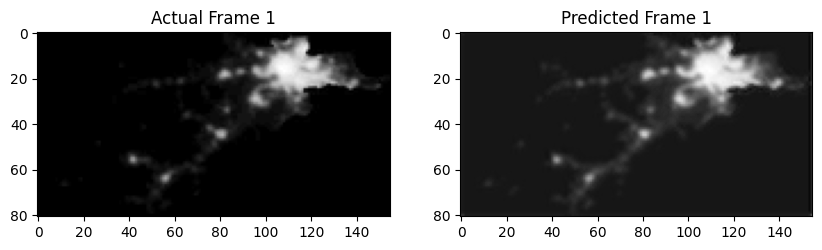

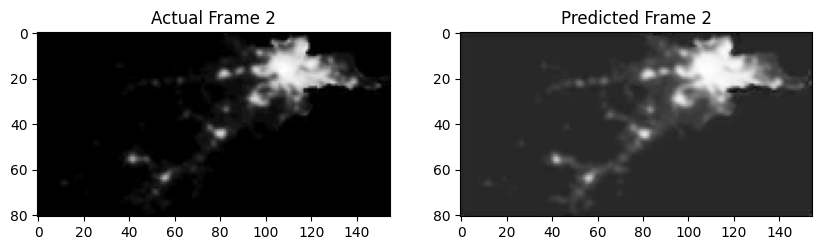

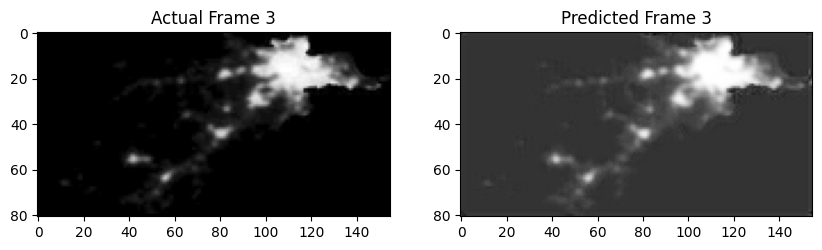

In [23]:
import matplotlib.pyplot as plt

# 1. Predict on Validation Data
predictions = model.predict(X_val)

def plot_frames(actual, predicted, index, save_dir=None):
    """
    Plot actual vs. predicted frames for a given sequence index.

    Parameters:
    - actual: Actual frames (ground truth).
    - predicted: Predicted frames from the model.
    - index: Index of the sequence to visualize.
    - save_dir: Directory to save the predicted frames. If None, frames are not saved.
    """
    sequence_length = actual.shape[1]

    for i in range(sequence_length):
        plt.figure(figsize=(10, 5))

        # Plot actual frame
        plt.subplot(1, 2, 1)
        plt.imshow(actual[index, i, :, :, 0], cmap='gray')
        plt.title(f"Actual Frame {i+1}")

        # Plot predicted frame
        plt.subplot(1, 2, 2)
        plt.imshow(predicted[index, i, :, :, 0], cmap='gray')
        plt.title(f"Predicted Frame {i+1}")

        # Save the predicted frame if save_dir is provided
        if save_dir:
            save_path = os.path.join(save_dir, f"predicted_frame_{i+1}.png")
            plt.imsave(save_path, predicted[index, i, :, :, 0], cmap='gray')

        plt.show()

# Directory to save the predicted frames
save_dir = '/content/drive/MyDrive/cgan/lstm'
plot_frames(Y_val, predictions, index=0, save_dir=save_dir)


## CONDITONALGAN PARTS

In [ ]:
from keras.layers import Input, Dense, Reshape, Flatten, Concatenate, Conv2D, Conv2DTranspose, UpSampling2D, LeakyReLU, Dropout, Add, BatchNormalization
from keras.models import Model
import tensorflow as tf

def res_block_gen(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding='same', activation='relu')(x)
    x = BatchNormalization()(x)
    x = Add()([shortcut, x])
    return x

# Generator with residual blocks
def build_generator_v2(condition_dim):
    condition = Input(shape=condition_dim)

    x = Conv2D(128, kernel_size=3, padding='same', activation='relu')(condition)
    x = res_block_gen(x, 128)
    x = Conv2D(64, kernel_size=3, padding='same', activation='relu')(x)
    x = res_block_gen(x, 64)
    x = Conv2D(32, kernel_size=3, padding='same', activation='relu')(x)
    x = res_block_gen(x, 32)
    x = Conv2D(1, kernel_size=3, padding='same', activation='sigmoid')(x)  # Grayscale image

    generator = Model(condition, x)
    return generator

def res_block_dis(x, filters, kernel_size=3):
    shortcut = x
    x = Conv2D(filters, kernel_size=kernel_size, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = Conv2D(filters, kernel_size=kernel_size, padding='same')(x)
    x = LeakyReLU(alpha=0.2)(x)
    shortcut = Conv2D(filters, kernel_size=kernel_size, strides=2, padding='same')(shortcut)
    x = Add()([shortcut, x])
    return x

def build_discriminator_v2(image_shape, condition_dim):
    image = Input(shape=image_shape)
    condition = Input(shape=condition_dim)

    x = res_block_dis(image, 32)
    x = Dropout(0.25)(x)

    x = res_block_dis(x, 64)
    x = BatchNormalization()(x)
    x = Dropout(0.25)(x)

    x = Flatten()(x)

    merged = Concatenate()([x, Flatten()(condition)])

    x = Dense(128, activation='relu')(merged)
    x = Dropout(0.25)(x)

    validity = Dense(1, activation='sigmoid')(x)

    discriminator = Model([image, condition], validity)
    return discriminator

condition_dim = (81, 155, 1)  # Output shape from the ConvLSTM model
image_shape = (81, 155, 1)

generator_v2 = build_generator_v2(condition_dim)
discriminator_v2 = build_discriminator_v2(image_shape, condition_dim)


In [ ]:
# 1. Compile the Discriminator
discriminator_v2.compile(optimizer=tf.keras.optimizers.Adam(0.00002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# 2. Compile the cGAN
# For the cGAN, we'll only train the generator
# discriminator_v2.trainable = False

condition = Input(shape=condition_dim)
generated_image = generator_v2(condition)
validity = discriminator_v2([generated_image, condition])

cgan = Model(condition, validity)
cgan.compile(optimizer=tf.keras.optimizers.Adam(0.00002, 0.5), loss='binary_crossentropy')

# 3. Training Loop
def train_cgan(epochs, batch_size, sample_interval, num_runs):
    real_labels = np.ones((batch_size, 1))
    fake_labels = np.zeros((batch_size, 1))

    for epoch in range(epochs):
        # Train the Discriminator
        idx = np.random.randint(0, X_train.shape[0], batch_size)
        real_images = Y_train[idx]
        conditions = X_train[idx]
        print(conditions.shape)
        # Assuming `conditions` is the output from the ConvLSTM model
        conditions_last_frame = conditions[:, -1, :, :, :]
        real_images_last_frame = real_images[:, -1, :, :, :]

        generated_images = generator_v2.predict(conditions_last_frame)

        d_loss_real = discriminator_v2.train_on_batch([real_images_last_frame, conditions_last_frame], real_labels)
        d_loss_fake = discriminator_v2.train_on_batch([generated_images, conditions_last_frame], fake_labels)
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train the Generator
        g_loss = cgan.train_on_batch(conditions_last_frame, real_labels)

        # Print progress
        print(f"{epoch}/{epochs} [D loss: {d_loss[0]} | D accuracy: {100 * d_loss[1]}] [G loss: {g_loss}]")

        # Save generated samples at sample intervals
        if epoch % sample_interval == 0:
            save_samples(epoch + num_runs)
            save_single_sample(epoch + num_runs)

def save_samples(epoch):
    # Number of samples to visualize
    num_samples = min(5, X_val.shape[0])

    # Extract conditions and corresponding real images
    conditions = X_val[:num_samples]
    real_images = Y_val[:num_samples]
    conditions_last_frame = conditions[:, -1, :, :, :]

    # Generate fake images
    generated_images = generator_v2.predict(conditions_last_frame)

    fig, axs = plt.subplots(num_samples, 2, figsize=(10, 5*num_samples))

    for i in range(num_samples):
        # Display real image
        axs[i, 0].imshow(real_images[i, -1, :, :, 0], cmap='gray')
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Real Image')

        # Display generated image
        axs[i, 1].imshow(generated_images[i, :, :, 0], cmap='gray')
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Generated Image')

    fig.tight_layout()
    fig.savefig(f"/content/drive/MyDrive/cgan/compare/cgan_comparison_epoch_{epoch}.png")
    plt.close()

def save_single_sample(epoch):
    # Select a single condition
    condition = X_val[0:1]  # Taking the first condition from the validation set
    condition_last_frame = condition[:, -1, :, :, :]

    # Generate the image
    generated_image = generator_v2.predict(condition_last_frame)

    # Extract the image from the batch and add the channel dimension
    single_image = generated_image[0, :, :, 0]
    single_image = np.expand_dims(single_image, axis=-1)  # Add the channel dimension

    # Save the image
    save_path = f"/content/drive/MyDrive/cgan/new/generated_image_epoch_{epoch}.png"
    save_img(save_path, single_image)





In [ ]:
train_cgan(epochs=1000, batch_size=3, sample_interval=50, num_runs=0)

(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 22ms/step


0/1000 [D loss: 1.323267589725674e-06 | D accuracy: 100.0] [G loss: 1.1059616764064195e-12]
1/1 [==============================] - 0s 22ms/step
(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 21ms/step
1/1000 [D loss: 2.0911426901193408e-07 | D accuracy: 100.0] [G loss: 3.914564883318117e-15]
(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 21ms/step
2/1000 [D loss: 1.8472108287426181e-09 | D accuracy: 100.0] [G loss: 3.789952726651613e-12]
(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 21ms/step
3/1000 [D loss: 2.483905370276318e-07 | D accuracy: 100.0] [G loss: 1.1798988960751112e-15]
(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 21ms/step
4/1000 [D loss: 1.4945181092684834e-07 | D accuracy: 100.0] [G loss: 3.878237334276275e-15]
(3, 3, 81, 155, 1)
1/1 [==============================] - 0s 20ms/step
5/1000 [D loss: 7.584398499481393e-07 | D accuracy: 100.0] [G loss: 6.376904087016251e-17]
(3, 3, 81, 155, 1)
1/1 [==================

In [ ]:
train_cgan(epochs=1000, batch_size=3, sample_interval=50, num_runs=1000)

In [ ]:
combined.save('/content/drive/MyDrive/LSTMCGAN/LSTM_model/cganwithD.h5')